In [ ]:
#Instalar librería
!pip install d2l

     |████████████████████████████████| 81kB 3.3MB/s 


#  Proyecto: predicción de precios de casas

**Equipo: XX;  
Integrantes: A,B,C;  
Claves únicas: CU-A, CU-B, CU-C.**

Inicio 22/02/2021, Entrega 03/03/2021 a las 2:30pm por correo electrónico identificandolo con `[DL-2021] Equipo XX`.

En este mini proyecto vamos a construir un modelo de predicción de precios de ventas de casas. Los datos son de 
una competencia en [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). El código incluido se encarga de descargar los datos, construir un modelo base y dejar los resultados en el formato de entrega. 
Lo que tendrán que hacer es

1. Desarrollar un mejor modelo predictivo. Encontrarás algunas pistas al final de este archivo. 
1. Hacer la entrega de tus resultados en Kaggle y obtener una captura de pantalla del _score_ de tus respuestas. 

<!--  Por favor incorpora impresion de pantalla de su puntaje -->
![](score.png)

Algunos puntos a considerar:

1. Comiencen lo mas pronto posible. El proceso de selección de hiper-parámetros es tardado y Kaggle sólo acepta un número limitado de entregas al día.
1. Trabajen en equipo. 

La calificación dependerá del lugar que ocupen dentro del _Leaderboard_ en relación con los demás equipos de la clase.

## Descargando y leyendo los datos

Los datos ya están separados en entrenamiento y prueba. Cada instancia (observación) incluye algunos atributos de las viviendas como el tipo de calle donde se encuentra, año de construcción, etc. Los atributos son variados y hay números enteros (año de construcción), etiquetas (tipo de techo), números de punto flotante, etc. Existen algunos datos faltantes y han sido marcados como `na`. La variable objetivo (el precio de venta) sólo está disponible en el conjunto de entrenamiento. 

La lectura y el procesamiento será hecho en [`pandas`](http://pandas.pydata.org/pandas-docs/stable/). Podrían necesitar instalarlo en su computadora. 

In [ ]:
import os
import requests
import zipfile
import tarfile
import hashlib

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
  def download(name, cache_dir=os.path.join('.', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
%config Completer.use_jedi = False

from d2l import tensorflow as d2l
import tensorflow as tf
import pandas as pd
import numpy as np

import math

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """


In [ ]:
# Librerías adicionales definidas por Rob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, ELU, Dropout #importé LeakyRELU y ELU
from tensorflow.python.client import device_lib
from keras.regularizers import l1, l2
print(device_lib.list_local_devices()) #Valido que puedo usar la GPU

#Incorporamos librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1974671890501917417
]


Lo siguiente se encargará de definir la ruta de dónde extraer los datos.

In [ ]:
DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

El conjunto de entrenamiento tiene 1,460 observaciones, 80 atributos, and una variable objetivo. El conjunto de prueba tiene 1,459 observaciones y 80 atributos.

In [ ]:
print("Entrenamiento: ",train_data.shape)
print("Prueba       : ", test_data.shape)

Entrenamiento:  (1460, 81)
Prueba       :  (1459, 80)


Podemos explorar los primeros 4 atributos, los últimos 2 atributos y el precio de venta (SalePrice) de las primeras 4 viviendas. Nota que en pandas necesitamos usar las ubicaciones como si fuera un slice de una matriz. Por eso utilizamos .iloc.

In [ ]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [ ]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


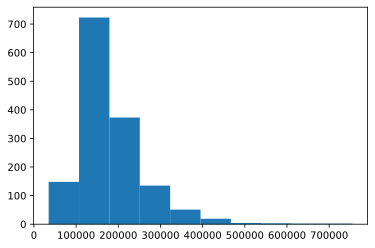

In [ ]:
# Hacer un histograma de los precios para ver la distribución
x = train_data['SalePrice']
plt.hist(x)
plt.show()

In [ ]:
# Extraer a una serie el precio original
precio_original = train_data['SalePrice']

In [ ]:
np.mean(precio_original)

180921.19589041095

In [ ]:
precio_original

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [ ]:
# Convertir a logaritmo (base 10) para lidiar con  el diferente orden de escalas
precio_log10 = np.log10(precio_original)

In [ ]:
np.mean(precio_log10)

5.221978956475622

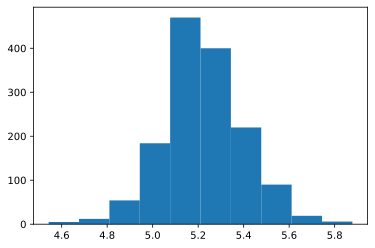

In [ ]:
#Graficar el valor transformado para ver la distribución del nuevo precio
x = precio_log10
plt.hist(x)
plt.show()

Vemos que los precios en logaritmo base 10 se centran en 5.2, equivalente a:

In [ ]:
10**5.221978956475622

166716.64288689545

Nota que el primer atributo es un identificador de la vivienda. Claramente éste no tendrá ningún poder predictivo. Por lo tanto lo podemos eliminar de los datos.

In [ ]:
# Notar que utilizar tanto los datos de entremiento como de test para el preprocesamiento no es del todo correcto, 
# Porque se incurre en filtrado de datos de no deberíamos conocer si por ejemplo llegara a aparecer un outlier en los datos nuevos

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [ ]:
all_features.shape

(2919, 79)

In [ ]:
# Ver que columnas tienen valor missing
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [ ]:
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Para variables tipo carácter y al ver la descripción de las variables en Kaggle, usaremos imputación a juicio reemplazando los missing por la categoría 'Missing'

In [ ]:
all_features.groupby('Electrical')['Electrical'].count()

Electrical
FuseA     188
FuseF      50
FuseP       8
Mix         1
SBrkr    2671
Name: Electrical, dtype: int64

In [ ]:
## Asignar la categoria missing a las variable categoricas e imputar la media a variables númericas

# CAMBIAR EL TIPO DE VARIABLE A DATOS QUE ESTE CODIFICADOS COMO NUMERICOS PERO SEAN CATEGORICOS
all_features['MSSubClass'] = all_features['MSSubClass'].astype(object)
all_features['MoSold'] = all_features['MoSold'].astype(object)
all_features['YrSold'] = all_features['YrSold'].astype(object)


## CATEGORICAS
all_features.MSZoning[all_features['MSZoning'].isnull()] = 'Missing'
all_features.Alley[all_features['Alley'].isnull()] = 'Missing'
all_features.Utilities[all_features['Utilities'].isnull()] = 'Missing'
all_features.Exterior1st[all_features['Exterior1st'].isnull()] = 'Missing'
all_features.Exterior2nd[all_features['Exterior2nd'].isnull()] = 'Missing'
all_features.MasVnrType[all_features['MasVnrType'].isnull()] = 'Missing'

all_features.BsmtQual[all_features['BsmtQual'].isnull()] = 'Missing'
all_features.BsmtCond[all_features['BsmtCond'].isnull()] = 'Missing'
all_features.BsmtExposure[all_features['BsmtExposure'].isnull()] = 'Missing'
all_features.BsmtFinType1[all_features['BsmtFinType1'].isnull()] = 'Missing'
all_features.BsmtFinType2[all_features['BsmtFinType2'].isnull()] = 'Missing'

all_features.KitchenQual[all_features['KitchenQual'].isnull()] = 'Missing'
all_features.Functional[all_features['Functional'].isnull()] = 'Missing'
all_features.FireplaceQu[all_features['FireplaceQu'].isnull()] = 'Missing'

all_features.GarageType[all_features['GarageType'].isnull()] = 'Missing'
all_features.GarageFinish[all_features['GarageFinish'].isnull()] = 'Missing'
all_features.GarageQual[all_features['GarageQual'].isnull()] = 'Missing'
all_features.GarageCond[all_features['GarageCond'].isnull()] = 'Missing'

all_features.PoolQC[all_features['PoolQC'].isnull()] = 'Missing'
all_features.Fence[all_features['Fence'].isnull()] = 'Missing'
all_features.MiscFeature[all_features['MiscFeature'].isnull()] = 'Missing'
all_features.SaleType[all_features['SaleType'].isnull()] = 'Missing'

all_features.Electrical[all_features['Electrical'].isnull()] = 'Missing'

## NUMERICAS
all_features['LotFrontage'].fillna(all_features['LotFrontage'].mean(), inplace=True)
all_features['MasVnrArea'].fillna(all_features['MasVnrArea'].mean(), inplace=True)

all_features['BsmtFinSF1'].fillna(all_features['BsmtFinSF1'].mean(), inplace=True)
all_features['BsmtFinSF2'].fillna(all_features['BsmtFinSF2'].mean(), inplace=True)
all_features['BsmtUnfSF'].fillna(all_features['BsmtUnfSF'].mean(), inplace=True)
all_features['TotalBsmtSF'].fillna(all_features['TotalBsmtSF'].mean(), inplace=True)
all_features['BsmtFullBath'].fillna(all_features['BsmtFullBath'].mean(), inplace=True)
all_features['BsmtHalfBath'].fillna(all_features['BsmtHalfBath'].mean(), inplace=True)

all_features['GarageYrBlt'].fillna(all_features['GarageYrBlt'].mean(), inplace=True)
all_features['GarageCars'].fillna(all_features['GarageCars'].mean(), inplace=True)
all_features['GarageArea'].fillna(all_features['GarageArea'].mean(), inplace=True)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Ahora ninguna variable tiene missings
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

## Procesamiento de datos

Como lo hemos mencionado antes, tenemos una gran variedad de tipo de datos. Antes de ajustar un modelo multicapa (MLP) necesitamos hacer un poco de procesamiento. Empezamos con los atributos numéricos. Necesitamos sustituir los valores faltantes. Una estrategia razonable es imputar el valor promedio cuando no se piensa que ha ocultado los valores es un mecanismo completamente aleatorio. Por otro lado, necesitamos estandarizar todas las variables en una misma escala. Buscamos que todas tengan media 0 y varianza igual a 1. Esto lo logramos con:

$$x \leftarrow \frac{x - \min(x)}{\max(x) - min(x)}$$

In [ ]:
#numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#all_features[numeric_features] = all_features[numeric_features].apply(
#    lambda x: (x - x.min()) / (x.max() - x.min()))
# Después de estandarizar, las medias son 0, por lo tanto los valores faltantes toman el valor de 0. 
#all_features = all_features.fillna(0)

Se hizo la prueba usando la transformación min max pero arrojaba nan en el rmse. se usará la trnasformación z-score

## Procesamiento de datos

Como lo hemos mencionado antes, tenemos una gran variedad de tipo de datos. Antes de ajustar un modelo multicapa (MLP) necesitamos hacer un poco de procesamiento. Empezamos con los atributos numéricos. Necesitamos sustituir los valores faltantes. Una estrategia razonable es imputar el valor promedio cuando no se piensa que ha ocultado los valores es un mecanismo completamente aleatorio. Por otro lado, necesitamos estandarizar todas las variables en una misma escala. Buscamos que todas tengan media 0 y varianza igual a 1. Esto lo logramos con:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

A continuación, tratamos los atributos discretos. Esto incluye variables como `MSZoning`. Los reemplazamos con  _one-hot encoding_ de la misma manera que transformamos los datos de clasificación multiclase en un vector de $ 0 $ y $ 1 $. Por ejemplo, `MSZoning` asume los valores `RL` y `RM`. Se asignan a los vectores $ (1,0) $ y $ (0,1) $ respectivamente. `Pandas` hace esto automáticamente por nosotros. 

In [ ]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 387)

In [ ]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass_20.0,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,...,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan,MoSold_1.0,MoSold_2.0,MoSold_3.0,MoSold_4.0,MoSold_5.0,MoSold_6.0,MoSold_7.0,MoSold_8.0,MoSold_9.0,MoSold_10.0,MoSold_11.0,MoSold_12.0,MoSold_nan,YrSold_2006.0,YrSold_2007.0,YrSold_2008.0,YrSold_2009.0,YrSold_2010.0,YrSold_nan,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Missing,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,-0.202033,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.29308,-0.934702,-0.444252,-0.773728,1.207172,-0.10118,0.413476,1.086836,-0.249852,0.781232,1.232388,0.169898,-0.207663,0.986680,-0.924153,1.000757,0.306475,0.348840,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.501785,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.29308,-0.629788,0.477029,0.261030,-0.784891,-0.10118,-0.471810,-0.819539,3.821764,0.781232,-0.756191,0.169898,-0.207663,-0.287709,0.623525,-0.084986,0.306475,-0.059782,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,-0.061269,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.29308,-0.288467,-0.299025,-0.610614,1.235163,-0.10118,0.563659,1.086836,-0.249852,0.781232,1.232388,0.169898,-0.207663,-0.287709,0.623525,0.920332,0.306475,0.627446,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,-0.436639,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.29308,-0.047266,-0.671168,-0.506118,0.978574,-0.10118,0.427309,1.086836,-0.249852,-1.027187,-0.756191,0.169898,-0.207663,0.349486,0.623525,0.799694,1.619684,0.785323,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4,0.689469,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.29308,-0.161040,0.211537,-0.037164,1.671364,-0.10118,1.377806,1.086836,-0.249852,0.781232,1.232388,1.385418,-0.207663,1.623875,0.623525,0.880119,1.619684,1.686149,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 387 entries, LotFrontage to SaleCondition_nan
dtypes: float64(33), uint8(354)
memory usage: 1.7 MB


Notar que sigue habiendo missings en variables como año o mes, los dejaremos.

Puedes ver que esta conversión aumenta el número de atributos de 79 a 386. Finalmente, a través del atributo `values` podemos extraer el formato NumPy del _data frame_ de Pandas y convertirlo en un tensor para usarse con Keras y Tensorflow.


In [ ]:
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
train_labels = tf.constant(
    #Usar la variable en logaritmo
    #precio_log10.values.reshape(-1, 1), dtype=tf.float32)
    # Prueba usando el valor original
    train_data.SalePrice.values.reshape(-1, 1), dtype=tf.float32)

In [ ]:
train_labels

<tf.Tensor: shape=(1460, 1), dtype=float32, numpy=
array([[208500.],
       [181500.],
       [223500.],
       ...,
       [266500.],
       [142125.],
       [147500.]], dtype=float32)>

## Entrenamiento

Para empezar, entrenamos un modelo lineal con pérdida cuadrática. Obviamente, esto no nos dará el mejor 
modelo de todos, pero proporciona una buena base de referencia para determinar el poder predictivo de los atributos. Esperaríamos que cualquier modelo más complejo sea capaz de vencer esta referencia.

In [ ]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(128, activation='relu'))
    net.add(tf.keras.layers.Dropout(0.2))
    net.add(tf.keras.layers.Dense(256, activation='relu'))
    net.add(tf.keras.layers.Dropout(0.2)) 
    net.add(tf.keras.layers.Dense(64, activation='relu'))
    net.add(tf.keras.layers.Dropout(0.2))
    net.add(tf.keras.layers.Dense(32, activation='relu'))
    net.add(tf.keras.layers.Dropout(0.2))           
    net.add(tf.keras.layers.Dense(16, activation='relu'))
    net.add(tf.keras.layers.Dropout(0.2))

    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

Los precios de las viviendas, como las acciones, son relativos. Es decir, probablemente nos interese más el error relativo $\frac{y - \hat {y}} {y}$ que el error absoluto. Por ejemplo, equivocarse en el precio de una casa en 100K USD es terrible en la zona rural de Ohio, donde el valor de la casa promedio es 125K USD. Por otro lado, si nos equivocamos en esta cantidad en Los Altos Hills, California, podemos estar orgullosos de la precisión de nuestro modelo (el precio medio de la vivienda supera los 4 millones).

Una forma de abordar este problema es medir la discrepancia en el logaritmo de las estimaciones de precios. De hecho, este es también el error que se está utilizando para medir la calidad en esta competencia. Después de todo, un valor pequeño $\delta$ de $\log y - \log \hat{y}$ se traduce en $e^{-\delta} \leq \frac {\hat {y}} {y} \leq e ^ \delta$. Esto nos lleva a considerar la siguiente función de pérdida:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [ ]:
def log_rmse(y_true, y_pred):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

A diferencia de lo que hemos hecho anteriormente, las siguientes funciones de entrenamiento utilizan el algoritmo de optimización de Adam. En comparación con el descenso de gradiente estocástico de mini-bloques utilizado anteriormente, el algoritmo de optimización de Adam es relativamente menos sensible a las tasas de aprendizaje. Esto se cubrirá con más detalle más adelante cuando discutamos los detalles sobre métodos de optimización.

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

## Validación cruzada

El procedimiento de validación cruzada se introdujo en la sección donde discutimos cómo seleccionar y evaluar modelos. Puedes ver la sección correspondiente en el libro. Le daremos un buen uso a esto para seleccionar el diseño del modelo y para ajustar los hiperparámetros. Primero, necesitamos una función que devuelva el i-ésimo pliegue de los datos en un procedimiento de validación cruzada con $K$ pliegues. Se procede a dividir el segmento i-ésimo como datos de validación y devolver el resto como datos de entrenamiento. 

**Nota:** esta no es la forma más eficiente de manejar datos y usaríamos algo mucho más inteligente si la cantidad de datos fuera considerablemente mayor. Por cuestiones didácticos lo omitimos y utilizamos las de abajo. 

In [ ]:
def get_k_fold_data(k, i, X, y):
    """ Extraemos el bloque i de los k posibles """
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

Los errores de entrenamiento y validación se promedian cuando entrenamos  KK  veces con la validación cruzada de  KK  pliegues.

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    """ Regresamos la perdida promedio de entrenamiento y validacion """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
            
        # Imprime la perdida en la iteracion i. Es decir, la perdida de 
        # entrenamiento con los K-1 bloques que se usaron para entrenar
        # y el i-esimo bloque se uso para validar
        
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
        
    return train_l_sum / k, valid_l_sum / k

## Selección de modelos

Para empezar, se escoge un conjunto de hiperparámetros al azar. Ustedes tendrán que refinar la selección de hiperparámetros para mejorar el modelo. Encontrar una buena opción puede llevar bastante tiempo, dependiendo de cuántas cosas se quiera optimizar. Dentro de lo razonable, el enfoque de validación cruzada de $K$-pliegues es resistente a múltiples pruebas. Sin embargo, si probamos una cantidad excesivamente grande de opciones, podría fallar, ya que podríamos tener suerte en la división de validación con un conjunto particular de hiperparámetros.

fold 1, train log rmse 0.061312, valid log rmse 0.134230
fold 2, train log rmse 0.041015, valid log rmse 0.153576
fold 3, train log rmse 0.075856, valid log rmse 0.151989
fold 4, train log rmse 0.037370, valid log rmse 0.133493
fold 5, train log rmse 0.031076, valid log rmse 0.157904
5-fold validation: avg train log rmse: 0.049326, avg valid log rmse: 0.146238


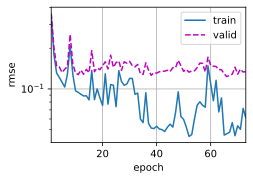

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 73, 0.05, 0, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.061942, valid log rmse 0.153132
fold 2, train log rmse 0.063431, valid log rmse 0.142519
fold 3, train log rmse 0.051877, valid log rmse 0.150742
fold 4, train log rmse 0.049264, valid log rmse 0.130788
fold 5, train log rmse 0.066932, valid log rmse 0.167278
5-fold validation: avg train log rmse: 0.058689, avg valid log rmse: 0.148892


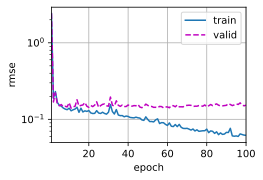

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.005, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.119240, valid log rmse 0.150422
fold 2, train log rmse 0.109348, valid log rmse 0.164821
fold 3, train log rmse 0.105382, valid log rmse 0.158711
fold 4, train log rmse 0.114261, valid log rmse 0.145842
fold 5, train log rmse 0.099691, valid log rmse 0.160077
5-fold validation: avg train log rmse: 0.109585, avg valid log rmse: 0.155975


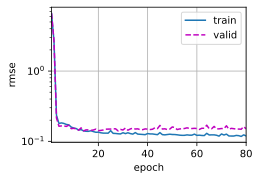

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 80, .001, 0.001, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.120598, valid log rmse 0.144834
fold 2, train log rmse 0.117193, valid log rmse 0.154333
fold 3, train log rmse 0.116459, valid log rmse 0.154988
fold 4, train log rmse 0.124179, valid log rmse 0.134914
fold 5, train log rmse 0.108522, valid log rmse 0.160503
5-fold validation: avg train log rmse: 0.117390, avg valid log rmse: 0.149914


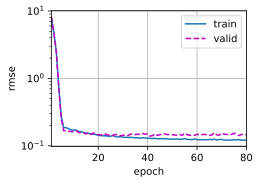

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 80, .0005, 0.0001, 32
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

Nota que a veces el número de errores de entrenamiento para un conjunto de hiperparámetros puede ser muy bajo, mientras que el errores para la validación cruzada puede ser mayor. Es muy probable que esto sea consecuencia de sobre-ajuste. Por lo tanto, cuando reducimos el error de entrenamiento, debemos verificar si el error en validación cruzada también se ha reducido.


##  Predicción y entrega de resultados

Ahora que sabemos lo que debería ser una buena elección de hiperparámetros, también podríamos usar todos los datos para entrenar (en lugar de solo $1-1/K$ de los datos que se usan en los segmentos de validación cruzada). El modelo que obtenemos de esta manera se puede aplicar al conjunto de prueba. Guardar las estimaciones en un archivo `CSV` simplificará la carga de los resultados en Kaggle.

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls],
             xlabel='epoch',
             ylabel='log rmse',
             xlim=[1, num_epochs],
             yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    print(test_data['SalePrice'].mean())
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Ahora usemos el modelo. Una buena prueba es ver si las predicciones en el conjunto completo se parecen a las del proceso de validación cruzada. Si lo hacen, es buen momento para subir nuestras predicciones a Kaggle.

train log rmse 0.119319
178684.75


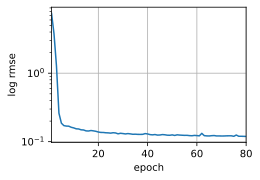

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

El archivo `submission.csv` será generado por función de arriba (CSV es uno de los formatos de archivo aceptados por Kaggle). A continuación, podemos enviar nuestras predicciones en Kaggle y esto las comparará con el precio real de la vivienda en el conjunto de prueba. Los pasos son bastante sencillos:

* Inicia sesión en el sitio web de Kaggle y visita la página del [concurso de predicción de precios de vivienda](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
* Haz click en el botón para "Enviar predicciones".
* Haz click en el botón "Cargar archivo de envío" en el cuadro en la parte inferior de la página y selecciona el archivo de predicción que desea cargar.
* Haz click en el botón "Realizar envío" en la parte inferior de la página para ver resultados. 

![](kaggle_submit2.png)

## Pistas y sugerencias

1. ¿Puedes mejorar el modelo minimizando directamente el logaritmo del precio venta? ¿Qué sucede si intentas predecir el precio en escala logarítmica?
1. ¿Es siempre una buena idea reemplazar los valores faltantes por la media? Sugerencia: ¿puedes construir una situación en la que los valores no falten al azar?
1. ¿Podemos pensar en una mejor representación para lidiar con los valores faltantes? Sugerencia: ¿Qué sucede si agrega una variable indicadora?
1. Mejora la puntuación en Kaggle ajustando los hiperparámetros a través de validación cruzada.
1. Mejora la puntuación mejorando el modelo (capas, unidades en las capas, regularización, dropout, `num_epochs`, `batch_size`).
1. ¿Qué sucede si no estandarizamos las características numéricas continuas como lo hemos hecho en esta sección?


## NOTA: 

1. El objetivo de este proyecto es: "Construir un modelo predictivo basado en MLPs considerando la arquitectura y los hiper-parametros asociados al entrenamiento". El objetivo *no* está centrado en _feature engineering_ (importante en aplicaciones en general, generalmente necesita de conocimiento de dominio). 
1. Para el ajuste de hiper-parámetros nos estamos basando en validación cruzada (no tenemos tantos datos). 
1. Existen herramientas de búsqueda de hiper-parámetros. Utilizarlas los pondría en una ventaja sobre los demás, pues no las hemos visto en clase y no hemos discutido las ideas que hay detrás de ellas. Por esto, el uso de herramientas automatizadas externas no forma parte de las habilidades básicas necesarias para la evaluación de este proyecto.

Nota para convertir este cuaderno a PDF. Si usas 'Archivo -> Descargar como -> PDF', puedes obtener el error de que `SVG` no puede convertir porque `inkscape` no está instalado y no puede encontrar imágenes PNG. La forma más sencilla es imprimir este cuaderno como PDF en el navegador. O puedes instalar `inkscape` para convertir `SVG` (en `macOS`, puedes usar homebrew `brew cask install xquartz inkscape`, en Ubuntu, puedes usar `sudo apt-get install inkscape`) y cambiar la URL de la imagen a nombres de archivo locales.